In [1]:
import yaml
import matplotlib.pyplot as plt
from lvmsurveysim import IFU, Telescope
from lvmsurveysim.schedule import ObservingPlan, Simulator, TileDB
from lvmsurveysim.target import TargetList
from lvmsurveysim.target import Target
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.visualization import MinMaxInterval, PercentileInterval, SqrtStretch, ImageNormalize
from regions import PixCoord, PolygonSkyRegion

In [2]:
with open('./smc.yaml', 'r') as f:
    tgt = yaml.safe_load(f)
tgt

{'SMC': {'coords': [13.1583, -72.8003],
  'region_type': 'ellipse',
  'frame': 'icrs',
  'region_params': {'a': 3.0, 'b': 1.78, 'pa': 45},
  'priority': 30,
  'observatory': 'LCO',
  'telescope': 'LVM-160',
  'max_airmass': 1.75,
  'min_shadowheight': 1.0,
  'exptime': 1200,
  'n_exposures': 9,
  'min_exposures': 3,
  'min_moon_dist': 45,
  'max_lunation': 0.25,
  'overhead': 1.1,
  'tiling_strategy': 'center_first',
  'tile_overlap': 0.0416,
  'group': ['MCs']}}

In [3]:
targets = TargetList(target_file='./smc.yaml')
print('Tiling Survey ...')
tiledb = TileDB(targets)
tiledb.tile_targets()
tiledb.tile_table.write('smc_tiles.fits', format='fits', overwrite=True)

Tiling Survey ...
Tiling target SMC


In [4]:
tbl = tiledb.tile_table
tbl

tile_id,target_index,target,telescope,ra,dec,pa,target_priority,tile_priority,airmass_limit,lunation_limit,hz_limit,moon_distance_limit,total_exptime,visit_exptime
int64,int64,str3,str7,float64,float64,float64,int64,int64,float64,float64,float64,int64,int64,int64
1000001,0,SMC,LVM-160,6.43766804734025,-75.16966993749213,6.424764439327347,30,1,1.75,0.25,1.0,45,10800,3600
1000002,0,SMC,LVM-160,9.28025146530119,-75.23404962535052,3.707811821178015,30,3,1.75,0.25,1.0,45,10800,3600
1000003,0,SMC,LVM-160,5.13637968718144,-74.91595632798729,7.666948160395025,30,1,1.75,0.25,1.0,45,10800,3600
1000004,0,SMC,LVM-160,7.927830407384575,-74.99638996382404,4.9998360163419715,30,3,1.75,0.25,1.0,45,10800,3600
1000005,0,SMC,LVM-160,10.742314468201258,-75.0428684358942,2.309672378710052,30,4,1.75,0.25,1.0,45,10800,3600
1000006,0,SMC,LVM-160,6.616853202343753,-74.7510726847016,6.251715823924972,30,3,1.75,0.25,1.0,45,10800,3600
1000007,0,SMC,LVM-160,9.384223244852707,-74.81373617250836,3.607370903945322,30,4,1.75,0.25,1.0,45,10800,3600
1000008,0,SMC,LVM-160,12.167861500249964,-74.84270994192255,0.9467446430794246,30,5,1.75,0.25,1.0,45,10800,3600
1000009,0,SMC,LVM-160,5.346620760101074,-74.4984508222557,7.464150239032642,30,2,1.75,0.25,1.0,45,10800,3600


In [5]:
ifu = IFU.from_config()
lvm160 = Telescope.from_config('LVM-160')

In [6]:
lvm160.plate_scale

<Quantity 348.42060811 arcsec / mm>

In [7]:
# Load SHASSA image
dat, hdr = fits.getdata('010.fl.fits.gz', header=True)
wcs = WCS(hdr)
print(dat.shape)

(998, 1014)


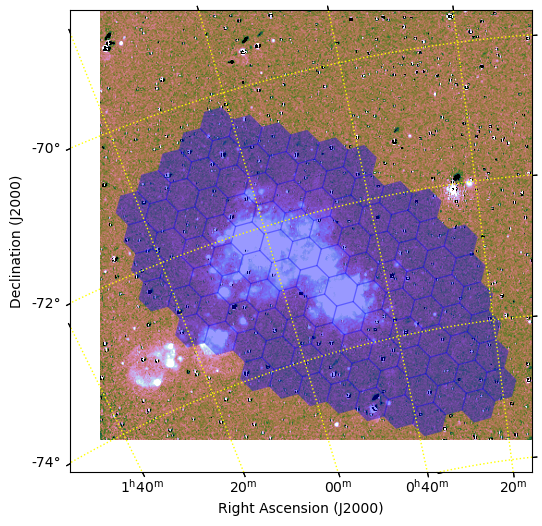

In [8]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection=wcs)
norm = ImageNormalize(dat, interval=PercentileInterval(98),
                      stretch=SqrtStretch())
ax.imshow(dat, origin='lower', cmap='cubehelix', norm=norm)
ax.coords[0].set_axislabel('Right Ascension (J2000)')
ax.coords[1].set_axislabel('Declination (J2000)')
ax.grid(color='yellow', ls=':', lw=1)
ax.set_xlim(0, 500)
ax.set_ylim(0, 500)
for p in tbl:
    patch = ifu.get_patch(scale=lvm160.plate_scale, centre=[p['ra'], p['dec']], pa=p['pa'],
                            edgecolor='None', linewidth=0.0, alpha=0.4, facecolor='b',
                            transform=ax.get_transform('fk5'))[0]
    ax.add_patch(patch)

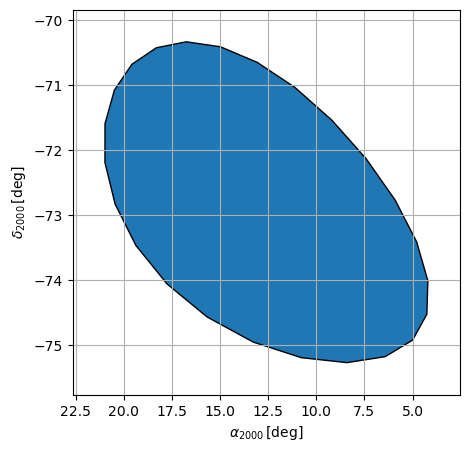

In [9]:
smc = Target.from_list('SMC',targets=tgt)
fig, ax = smc.plot()
fig.set_figheight(5)
fig.set_figwidth(5)
ax.invert_xaxis()

In [10]:
ras  = smc.region.vertices().T[0]
decs = smc.region.vertices().T[1]
print(ras)
print(decs)

[19.56982247 20.48122434 20.9691054  20.97242216 20.44347994 19.36000266
 17.74107206 15.66343347 13.27138798 10.77184662  8.40918345  6.42322682
  5.00377192  4.25864378  4.20574781  4.78749319  5.89720253  7.40599595
  9.18296959 11.10672806 13.06968289 14.97766285 16.74716423 18.30191037
 19.56982247]
[-70.67897966 -71.0770245  -71.59250773 -72.1903     -72.82966276
 -73.4670245  -74.05895007 -74.56510072 -74.95098311 -75.1903
 -75.26674234 -75.17510072 -74.92162034 -74.5235755  -74.00809227
 -73.4103     -72.77093724 -72.1335755  -71.54164993 -71.03549928
 -70.64961689 -70.4103     -70.33385766 -70.42549928 -70.67897966]


In [11]:
vertices = SkyCoord(ras, decs, unit='deg', frame='fk5')
smc_skyreg = PolygonSkyRegion(vertices=vertices)

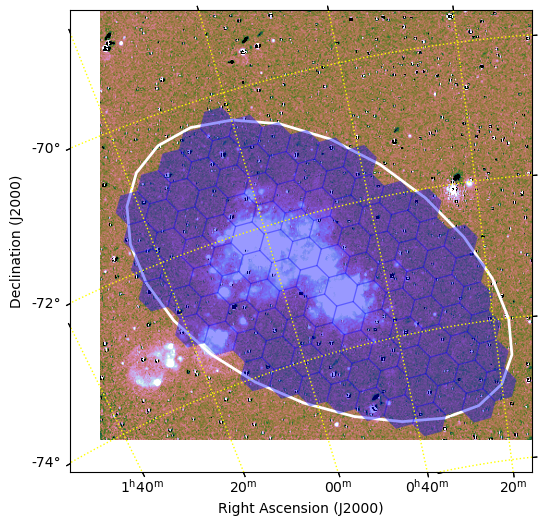

In [12]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection=wcs)
norm = ImageNormalize(dat, interval=PercentileInterval(98),
                      stretch=SqrtStretch())
ax.imshow(dat, origin='lower', cmap='cubehelix', norm=norm)
ax.coords[0].set_axislabel('Right Ascension (J2000)')
ax.coords[1].set_axislabel('Declination (J2000)')
ax.grid(color='yellow', ls=':', lw=1)
ax.set_xlim(0, 500)
ax.set_ylim(0, 500)
smc_skyreg.to_pixel(wcs).plot(ax=ax, color='w', lw=2.0)
for p in tbl:
    patch = ifu.get_patch(scale=lvm160.plate_scale, centre=[p['ra'], p['dec']], pa=p['pa'],
                            edgecolor='None', linewidth=0.0, alpha=0.4, facecolor='b',
                            transform=ax.get_transform('fk5'))[0]
    ax.add_patch(patch)

In [13]:
# Load MCELS image
dat, hdr = fits.getdata('mosaic_ha_02_sub.37.fits', header=True)
wcs = WCS(hdr)
print(dat.shape)

(8500, 9400)


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '22/11/1997' to '1997-11-22''. [astropy.wcs.wcs]


152425.4


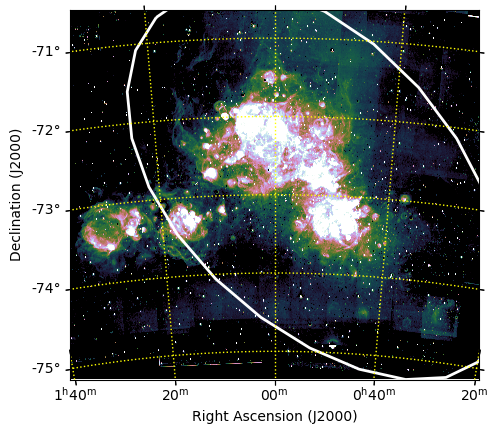

In [14]:
fig = plt.figure()
ax = fig.add_subplot(projection=wcs)
vmin, vmax = MinMaxInterval().get_limits(dat)
print(vmax)
norm = ImageNormalize(dat, vmin=0, vmax=120,
                      stretch=SqrtStretch())
ax.imshow(dat, origin='lower', cmap='cubehelix', norm=norm)
ax.coords[0].set_axislabel('Right Ascension (J2000)')
ax.coords[1].set_axislabel('Declination (J2000)')
ax.grid(color='yellow', ls=':', lw=1)
smc_skyreg.to_pixel(wcs).plot(ax=ax, color='w', lw=2.0)


In [15]:
# Load GASKAP image
dat, hdr = fits.getdata('SMC_askap_parkes_PBC_K_mom0.fits', header=True)
wcs = WCS(hdr,naxis=2)
print(dat.shape)

(1, 3471, 3901)


7294.0073


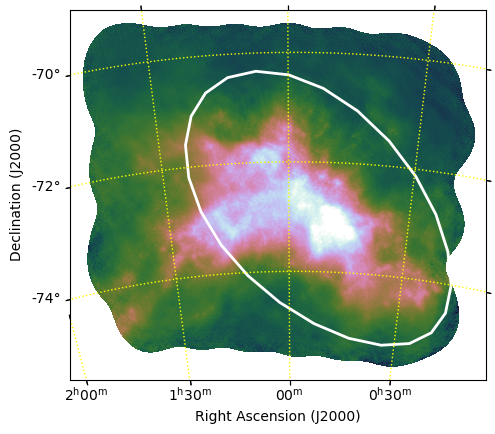

In [16]:
fig = plt.figure()
ax = fig.add_subplot(projection=wcs)
vmin, vmax = MinMaxInterval().get_limits(dat)
print(vmax)
norm = ImageNormalize(dat, interval=PercentileInterval(99),
                      stretch=SqrtStretch())
ax.imshow(dat[0], origin='lower', cmap='cubehelix', norm=norm)
ax.coords[0].set_axislabel('Right Ascension (J2000)')
ax.coords[1].set_axislabel('Declination (J2000)')
ax.grid(color='yellow', ls=':', lw=1)
smc_skyreg.to_pixel(wcs).plot(ax=ax, color='w', lw=2.0)